In [1]:
########## R Code: Gastric Lymphoma Survival Analysis
library(survival)
library(survminer)
library(dplyr)
library(stringr)
library(lubridate)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# 1. Load Data
# Ensure your CSV has columns like: 'age', 'sex', 'year_diag'
raw_data <- read.csv("data/data.csv")

In [3]:
# 1. Define Tumor Location Groups
# We use the 'Localiz_tumor_r' column from your summary
survival_data <- raw_data %>%
  mutate(
    # Create broad location categories
    Site_Group = case_when(
      str_detect(Localiz_tumor_r, "Estómago") ~ "Gastric",
      str_detect(Localiz_tumor_r, "Ganglios") ~ "Nodal",
      TRUE ~ "Extranodal (Non-Gastric)"
    ),
    Site_Group = factor(Site_Group, levels = c("Nodal", "Gastric", "Extranodal (Non-Gastric)")),

    # Ensure Dates/Time are ready (using the code we fixed earlier)
    Date_Diagnosis = ymd(as.character(Fecha_diag)),
    Date_LastContact = ymd(as.character(Fecha_ultcont)),
    Date_Death = ymd(as.character(Fecha_fall)),
    OS_status = case_when(
      as.character(Estado_vital) == "Fallecido" ~ 1,
      as.character(Estado_vital) == "Vivo" ~ 0,
      TRUE ~ NA_real_
    ),
    End_Date = if_else(OS_status == 1, Date_Death, Date_LastContact),
    OS_time = as.numeric(difftime(End_Date, Date_Diagnosis, units = "days")) / 30.4375
  ) %>%
  filter(!is.na(OS_time), OS_time > 0, !is.na(OS_status))

In [6]:
# 2. Fit Survival Model
fit_site <- survfit(Surv(OS_time, OS_status) ~ Site_Group, data = survival_data)

# 3. Generate Plot
p_site <- ggsurvplot(
  fit_site,
  data = survival_data,
  linewidth = 1,
  palette = c("#2E9FDF", "#E7B800", "#FC4E07"), # Blue, Yellow, Red
  conf.int = FALSE,
  pval = TRUE,
  risk.table = TRUE,
  title = "Survival by Tumor Location (Gastric vs. Nodal)",
  xlab = "Time (Months)",
  legend.labs = c("Nodal", "Gastric", "Other Extranodal"),
  ggtheme = theme_classic(base_size = 14)
)

In [7]:
# 4. Save
dir.create("images", showWarnings = FALSE)
png("images/Figure_Gastric_Survival.png", width = 10, height = 8, units = "in", res = 300)
print(p_site)
dev.off()

print("Gastric Survival Curve Saved.")

Ignoring unknown labels:
• colour : "Strata"


png 
  2

[1] "Gastric Survival Curve Saved."


Ignoring unknown labels:
• colour : "Strata"


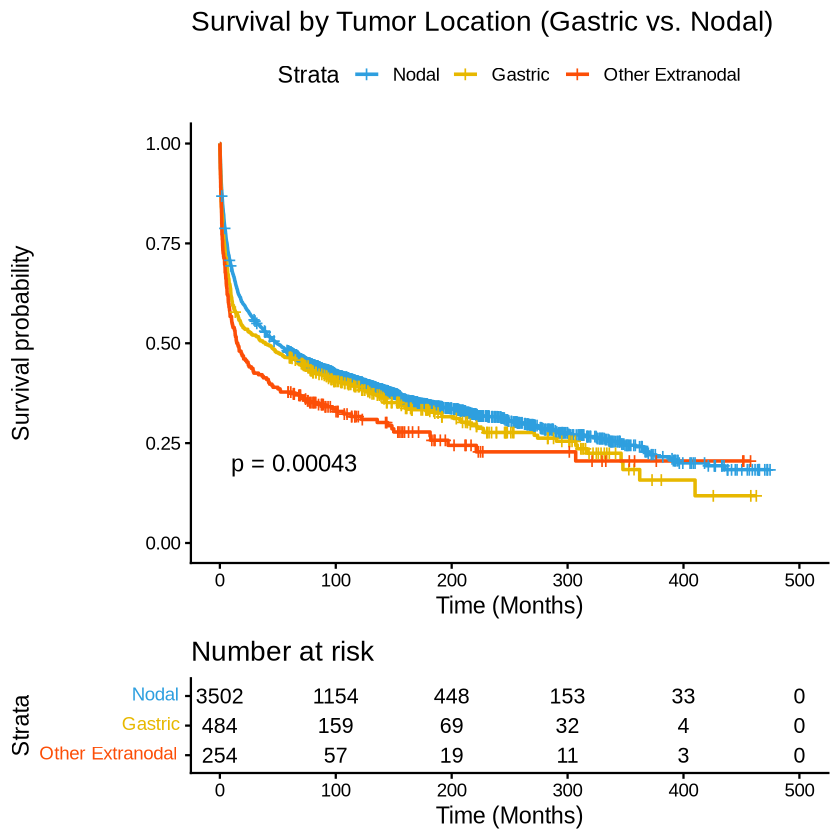

In [8]:
p_site